In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
import json
from pathlib import Path

from pyscipopt import Model
from pyscipopt import quicksum

In [3]:
instances_fps = list(Path('../data/raw/').glob('97_9_*.json'))

instance_fp = instances_fps[1]

with open(instance_fp) as f:
    instance = json.load(f)

instance.keys()

dict_keys(['subs', 'jobs', 'T', 'power_use', 'power_resource', 'min_cpu_time', 'max_cpu_time', 'min_job_period', 'max_job_period', 'min_startup', 'max_startup', 'priority', 'win_min', 'win_max'])

In [4]:
soc_inicial = 0.7
limite_inferior = 0.0
ef = 0.9 
v_bat = 3.6 
q = 5
bat_usage = 5

priority = instance['priority'] # prioridade de cada tarefa
uso_p = instance['power_use'] # recurso utilizado por cada tarefa
min_statup = instance['min_startup'] # tempo mínimo de vezes que uma tarefa pode iniciar
max_statup = instance['max_startup'] # tempo máximo de vezes que uma tarefa pode iniciar
min_cpu_time = instance['min_cpu_time'] # tempo mínimo de unidades de tempo que uma tarefa pode consumir em sequência
max_cpu_time = instance['max_cpu_time'] # tempo máximo de unidades de tempo que uma tarefa pode consumir em sequência
min_periodo_job = instance['min_job_period'] # tempo mínimo que uma tarefa deve esperar para se repetir
max_periodo_job = instance['max_job_period'] # tempo máximo que uma tarefa pode esperar para se repetir
win_min = instance['win_min']
win_max = instance['win_max']
recurso_p = instance['power_resource']  # this was a typo while generating the instances

T = instance['T']
J = instance['jobs']

model = Model('ONTS')

# create decision variables
x = {}
phi = {}
alpha = {}
soc = {}
i = {}
b = {}

for j in range(J):
    x[j] = {}
    phi[j] = {}
for t in range(T):
    alpha[t] = model.addVar(lb=0, ub=1, vtype="CONTINUOUS")
    soc[t] = model.addVar(vtype="CONTINUOUS")
    i[t] = model.addVar(lb=None, vtype="CONTINUOUS")
    b[t] = model.addVar(lb=None, vtype="CONTINUOUS")

    for j in range(J):
        x[j][t] = model.addVar(vtype="BINARY")
        phi[j][t] = model.addVar(vtype="BINARY")

# set objective
model.setObjective(quicksum(priority[j] * x[j][t] for j in range(J) for t in range(T)), "maximize")

# phi defines startups of jobs
for t in range(T):
    for j in range(J):
        if t == 0:
            model.addCons(phi[j][t] >= x[j][t] - 0)
        else:
            model.addCons(phi[j][t] >= x[j][t] - x[j][t - 1])

        model.addCons(phi[j][t] <= x[j][t])

        if t == 0:
            model.addCons(phi[j][t] <= 2 - x[j][t] - 0)
        else:
            model.addCons(phi[j][t] <= 2 - x[j][t] - x[j][t - 1])


# minimum and maximum number of startups of a job
for j in range(J):
    model.addCons(quicksum(phi[j][t] for t in range(T)) >= min_statup[j])
    model.addCons(quicksum(phi[j][t] for t in range(T)) <= max_statup[j])

    ###############################
    # precisa ajustar

    # execution window
    model.addCons(quicksum(x[j][t] for t in range(win_min[j])) == 0)
    model.addCons(quicksum(x[j][t] for t in range(win_max[j], T)) == 0)

for j in range(J):
    # minimum period between jobs
    for t in range(0, T - min_periodo_job[j] + 1):
        model.addCons(quicksum(phi[j][t_] for t_ in range(t, t + min_periodo_job[j])) <= 1)

    # periodo máximo entre jobs
    for t in range(0, T - max_periodo_job[j] + 1):
        model.addCons(quicksum(phi[j][t_] for t_ in range(t, t + max_periodo_job[j])) >= 1)

    # min_cpu_time das jobs
    for t in range(0, T - min_cpu_time[j] + 1):
        model.addCons(quicksum(x[j][t_] for t_ in range(t, t + min_cpu_time[j])) >= min_cpu_time[j] * phi[j][t])

    # max_cpu_time das jobs
    for t in range(0, T - max_cpu_time[j]):
        model.addCons(quicksum(x[j][t_] for t_ in range(t, t + max_cpu_time[j] + 1)) <= max_cpu_time[j])

    # min_cpu_time no final do periodo
    for t in range(T - min_cpu_time[j] + 1, T):
        model.addCons(quicksum(x[j][t_] for t_ in range(t, T)) >= (T - t) * phi[j][t])

################################
# Add power constraints
for t in range(T):
    model.addCons(quicksum(uso_p[j] * x[j][t] for j in range(J)) <= recurso_p[t] + bat_usage * v_bat * (1 - alpha[t]))

################################
# Bateria
################################

for t in range(T):
    model.addCons(
        (quicksum(uso_p[j] * x[j][t] for j in range(J)) + b[t] == recurso_p[t])
    )

# Define the i_t, SoC_t constraints in Gurobi
for t in range(T):
    # P = V * I 
    model.addCons(b[t] / v_bat >= i[t])

    if t == 0:
        # SoC(1) = SoC(0) + p_carga[1]/60
        model.addCons(soc[t] == soc_inicial + (ef / q) * (i[t] / 60))
    else:
        # SoC(t) = SoC(t-1) + (ef / Q) * I(t)
        model.addCons(soc[t] == soc[t - 1] + (ef / q) * (i[t] / 60))

    # Set the lower and upper limits on SoC
    model.addCons(limite_inferior <= soc[t])
    model.addCons(soc[t] <= 1)

model.setParam('limits/time', 10)

In [5]:
model.optimize()

presolving:
(round 1, fast)       260 del vars, 442 del conss, 0 add conss, 558 chg bounds, 112 chg sides, 109 chg coeffs, 0 upgd conss, 0 impls, 1332 clqs
(round 2, fast)       262 del vars, 548 del conss, 0 add conss, 558 chg bounds, 112 chg sides, 109 chg coeffs, 0 upgd conss, 0 impls, 1348 clqs
   (0.1s) running MILP presolver
   (0.1s) MILP presolver (7 rounds): 43 aggregations, 0 fixings, 0 bound changes
(round 3, medium)     305 del vars, 548 del conss, 0 add conss, 558 chg bounds, 112 chg sides, 109 chg coeffs, 0 upgd conss, 0 impls, 1330 clqs
(round 4, fast)       305 del vars, 600 del conss, 0 add conss, 558 chg bounds, 112 chg sides, 109 chg coeffs, 0 upgd conss, 0 impls, 1331 clqs
(round 5, exhaustive) 305 del vars, 637 del conss, 0 add conss, 558 chg bounds, 112 chg sides, 109 chg coeffs, 0 upgd conss, 0 impls, 1331 clqs
(round 6, exhaustive) 305 del vars, 637 del conss, 0 add conss, 558 chg bounds, 112 chg sides, 109 chg coeffs, 4691 upgd conss, 0 impls, 1331 clqs
(round 

In [4]:
from src.problem import get_model_scip

model = get_model_scip(instance, timeout=30, new_ineq=True)

model.optimize()

best_sol = model.getBestSol()
sol_vals = {var.name: model.getSolVal(best_sol, var) for var in model.getVars()}

presolving:
(round 1, fast)       139 del vars, 1103 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 272 chg coeffs, 0 upgd conss, 0 impls, 2625 clqs
(round 2, fast)       141 del vars, 1172 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 272 chg coeffs, 0 upgd conss, 0 impls, 2630 clqs
   (0.1s) running MILP presolver
   (0.2s) MILP presolver (8 rounds): 42 aggregations, 0 fixings, 0 bound changes
(round 3, medium)     183 del vars, 1172 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 272 chg coeffs, 0 upgd conss, 0 impls, 2612 clqs
(round 4, fast)       183 del vars, 1226 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 506 chg coeffs, 0 upgd conss, 0 impls, 2612 clqs
(round 5, exhaustive) 183 del vars, 1634 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 506 chg coeffs, 0 upgd conss, 0 impls, 2612 clqs
(round 6, exhaustive) 183 del vars, 1634 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 506 chg coeffs, 6570 upgd conss, 0 impls, 2612 clqs
(

In [15]:
model = get_model_scip(instance, timeout=30, new_ineq=True)

new_sol = model.createSol()

for v in model.getVars():
    model.setSolVal(new_sol, v, sol_vals[v.name])

model.addSol(new_sol)

model.optimize()

1/1 feasible solution given by solution candidate storage, new primal bound 2.953000e+03

presolving:
(round 1, fast)       139 del vars, 1103 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 272 chg coeffs, 0 upgd conss, 0 impls, 2625 clqs
(round 2, fast)       141 del vars, 1172 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 272 chg coeffs, 0 upgd conss, 0 impls, 2630 clqs
   (0.1s) running MILP presolver
   (0.1s) MILP presolver (8 rounds): 42 aggregations, 0 fixings, 0 bound changes
(round 3, medium)     183 del vars, 1172 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 272 chg coeffs, 0 upgd conss, 0 impls, 2612 clqs
(round 4, fast)       183 del vars, 1226 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 506 chg coeffs, 0 upgd conss, 0 impls, 2612 clqs
(round 5, exhaustive) 183 del vars, 1634 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 506 chg coeffs, 0 upgd conss, 0 impls, 2612 clqs
(round 6, exhaustive) 183 del vars, 1634 del conss, 0 add c

In [5]:
model = get_model_scip(instance, timeout=30, new_ineq=True)

# new_sol = model.createPartialSol()
new_sol = model.createSol()

for v in model.getVars():
    if v.name.startswith('x('):
        model.setSolVal(new_sol, v, sol_vals[v.name])

model.addSol(new_sol)

model.optimize()

  [linear] <C1_j0_t0>: <phi(0,0)>[B] (+0) -<x(0,0)>[B] (+1) >= 0;
;
violation: left hand side is violated by 1
all 1 solutions given by solution candidate storage are infeasible

presolving:
(round 1, fast)       139 del vars, 1103 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 272 chg coeffs, 0 upgd conss, 0 impls, 2625 clqs
(round 2, fast)       141 del vars, 1172 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 272 chg coeffs, 0 upgd conss, 0 impls, 2630 clqs
   (0.1s) running MILP presolver
   (0.1s) MILP presolver (8 rounds): 42 aggregations, 0 fixings, 0 bound changes
(round 3, medium)     183 del vars, 1172 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 272 chg coeffs, 0 upgd conss, 0 impls, 2612 clqs
(round 4, fast)       183 del vars, 1226 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 506 chg coeffs, 0 upgd conss, 0 impls, 2612 clqs
(round 5, exhaustive) 183 del vars, 1634 del conss, 0 add conss, 540 chg bounds, 245 chg sides, 506 chg coeffs, 0 u

: 

: 

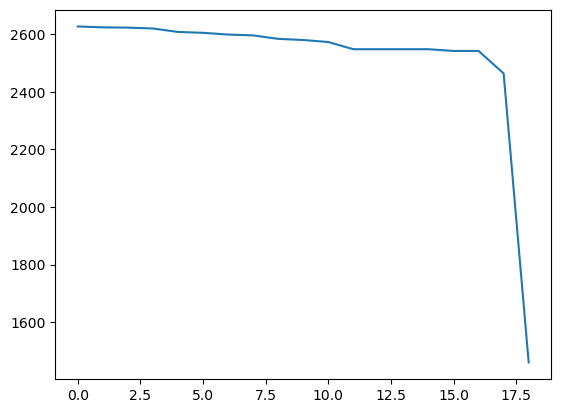

In [18]:
import matplotlib.pyplot as plt

plt.plot([model.getSolObjVal(s) for s in model.getSols()])
plt.show()

In [40]:
for v in model.getSols()[0]:
    print(v)

TypeError: Argument 'expr' has incorrect type (expected pyscipopt.scip.Expr, got int)

In [58]:
model.getSols()[0]

TypeError: Argument 'expr' has incorrect type (expected pyscipopt.scip.Expr, got str)

In [66]:
model.getObjective()

Expr({Term(x(0,0)): 7.0, Term(x(0,1)): 7.0, Term(x(0,2)): 7.0, Term(x(0,3)): 7.0, Term(x(0,4)): 7.0, Term(x(0,5)): 7.0, Term(x(0,6)): 7.0, Term(x(0,7)): 7.0, Term(x(0,8)): 7.0, Term(x(0,9)): 7.0, Term(x(0,10)): 7.0, Term(x(0,11)): 7.0, Term(x(0,12)): 7.0, Term(x(0,13)): 7.0, Term(x(0,14)): 7.0, Term(x(0,15)): 7.0, Term(x(0,16)): 7.0, Term(x(0,17)): 7.0, Term(x(0,18)): 7.0, Term(x(0,19)): 7.0, Term(x(0,20)): 7.0, Term(x(0,21)): 7.0, Term(x(0,22)): 7.0, Term(x(0,23)): 7.0, Term(x(0,24)): 7.0, Term(x(0,25)): 7.0, Term(x(0,26)): 7.0, Term(x(0,27)): 7.0, Term(x(0,28)): 7.0, Term(x(0,29)): 7.0, Term(x(0,30)): 7.0, Term(x(0,31)): 7.0, Term(x(0,32)): 7.0, Term(x(0,33)): 7.0, Term(x(0,34)): 7.0, Term(x(0,35)): 7.0, Term(x(0,36)): 7.0, Term(x(0,37)): 7.0, Term(x(0,38)): 7.0, Term(x(0,39)): 7.0, Term(x(0,40)): 7.0, Term(x(0,41)): 7.0, Term(x(0,42)): 7.0, Term(x(0,43)): 7.0, Term(x(0,44)): 7.0, Term(x(0,45)): 7.0, Term(x(0,46)): 7.0, Term(x(0,47)): 7.0, Term(x(0,48)): 7.0, Term(x(0,49)): 7.0, Term

In [77]:
model.getVars()[0].name

'x(0,0)'

# OR-tools

In [74]:
from ortools.linear_solver import pywraplp

help(pywraplp.Solver.CreateSolver)

Help on function CreateSolver in module ortools.linear_solver.pywraplp:

CreateSolver(solver_id)
    Recommended factory method to create a MPSolver instance, especially in
    non C++ languages.
    
    It returns a newly created solver instance if successful, or a nullptr
    otherwise. This can occur if the relevant interface is not linked in, or if
    a needed license is not accessible for commercial solvers.
    
    Ownership of the solver is passed on to the caller of this method.
    It will accept both string names of the OptimizationProblemType enum, as
    well as a short version (i.e. "SCIP_MIXED_INTEGER_PROGRAMMING" or "SCIP").
    
    solver_id is case insensitive, and the following names are supported:
      - CLP_LINEAR_PROGRAMMING or CLP
      - CBC_MIXED_INTEGER_PROGRAMMING or CBC
      - GLOP_LINEAR_PROGRAMMING or GLOP
      - BOP_INTEGER_PROGRAMMING or BOP
      - SAT_INTEGER_PROGRAMMING or SAT or CP_SAT
      - SCIP_MIXED_INTEGER_PROGRAMMING or SCIP
      - GURO

In [1]:
from ortools.linear_solver import pywraplp

# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    print('ERROR')

infinity = solver.infinity()
# x and y are integer non-negative variables.
x = solver.IntVar(0.0, infinity, 'x')
y = solver.IntVar(0.0, infinity, 'y')

print('Number of variables =', solver.NumVariables())

# x + 7 * y <= 17.5.
solver.Add(x + 7 * y <= 17.5)

# x <= 3.5.
solver.Add(x <= 3.5)

print('Number of constraints =', solver.NumConstraints())

# Maximize x + 10 * y.
solver.Maximize(x + 10 * y)

print(f'Solving with {solver.SolverVersion()}')
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL:
    print('Solution:')
    print('Objective value =', solver.Objective().Value())
    print('x =', x.solution_value())
    print('y =', y.solution_value())
else:
    print('The problem does not have an optimal solution.')

print('\nAdvanced usage:')
print('Problem solved in %f milliseconds' % solver.wall_time())
print('Problem solved in %d iterations' % solver.iterations())
print('Problem solved in %d branch-and-bound nodes' % solver.nodes())

ERROR


W0000 00:00:1682363685.535578  696382 linear_solver.cc:644] Support for SCIP not linked in, or the license was not found.


AttributeError: 'NoneType' object has no attribute 'infinity'